In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from scipy.linalg import sqrtm
from statsmodels.stats.correlation_tools import cov_nearest
from torchdiffeq import odeint

from ml import KramersMoyal, load_kernels_dict
from neural_ode import ODEfunc, RunningAverageMeter
from plot import ImperialColors, plot_simulation
from potenciala import BucketMethod, VectorTimeSeries
from stochastic import (EulerMaruyama, SpatialNearestDriftMultivariate, ConstantDiffusionMultivariate)

In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load VectorTimeSeries and drift and diffusion coefficients

In [5]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)
expected_drift_kde_df = KramersMoyal.obtain_first_coefficient_vector(kernels_dict=d_1_dict)

d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)
second_km_kde_matrix = KramersMoyal.obtain_second_coefficient_matrix(diag_kernels_dict=d_2_diag_dict, 
                                                                     non_diag_kernels_dict=d_2_non_diag_dict)

drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

sqrt_diff_matrix_kde = sqrtm(cov_nearest(cov=2*second_km_kde_matrix, threshold=1e-14))
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

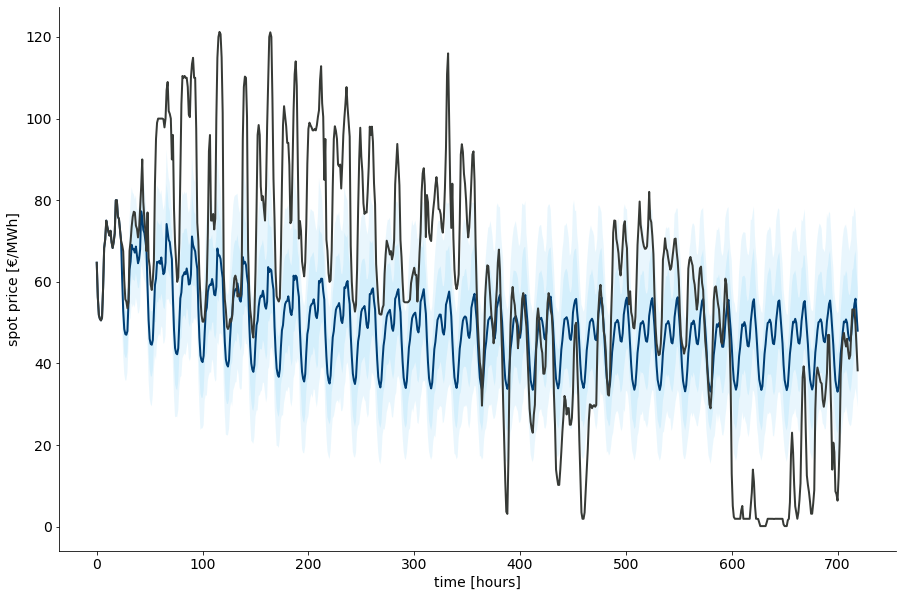

In [6]:
sim_periods = 30
x_df = df_raw[df_raw["date"] >= "2021-01-05"].iloc[:24*sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=1_000, periods=sim_periods, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=1024)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

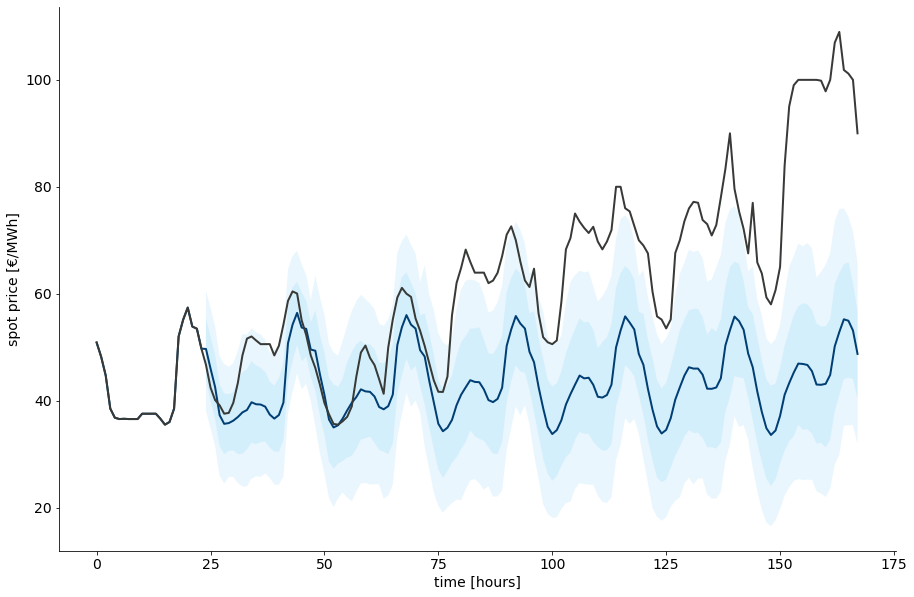

In [7]:
sim_periods = 7
x_df = df_raw[df_raw["date"] >= "2021-01-01"].iloc[:24*sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=1_000, periods=sim_periods, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=1024)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

### Compute difference between simulation and external drift to generate training set

In [8]:
diff_df = sim_df.subtract(x_df_kde.reset_index()["spain"], axis="index")
diff_df.index = pd.RangeIndex(start=1, stop=diff_df.index.max()+2, step=1)

hour_indexes = np.vstack([np.arange(1, 25, 1) + 24*i for i in range(sim_periods)]).T

In [9]:
hours_list = np.arange(1, 25)
ts = np.arange(0, sim_periods)
multi_idx = pd.MultiIndex.from_product([hours_list, ts])
hour_diff_df = pd.DataFrame(index=multi_idx, columns=diff_df.columns, dtype=np.float)

for i, h in enumerate(hours_list):
    hour_diff_df.loc[h] = diff_df.loc[hour_indexes[i]].values

/var/folders/n4/4pcf4gm94bsfkqcmfpznj3nh0000gp/T/ipykernel_32689/2641513247.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hour_diff_df = pd.DataFrame(index=multi_idx, columns=diff_df.columns, dtype=np.float)


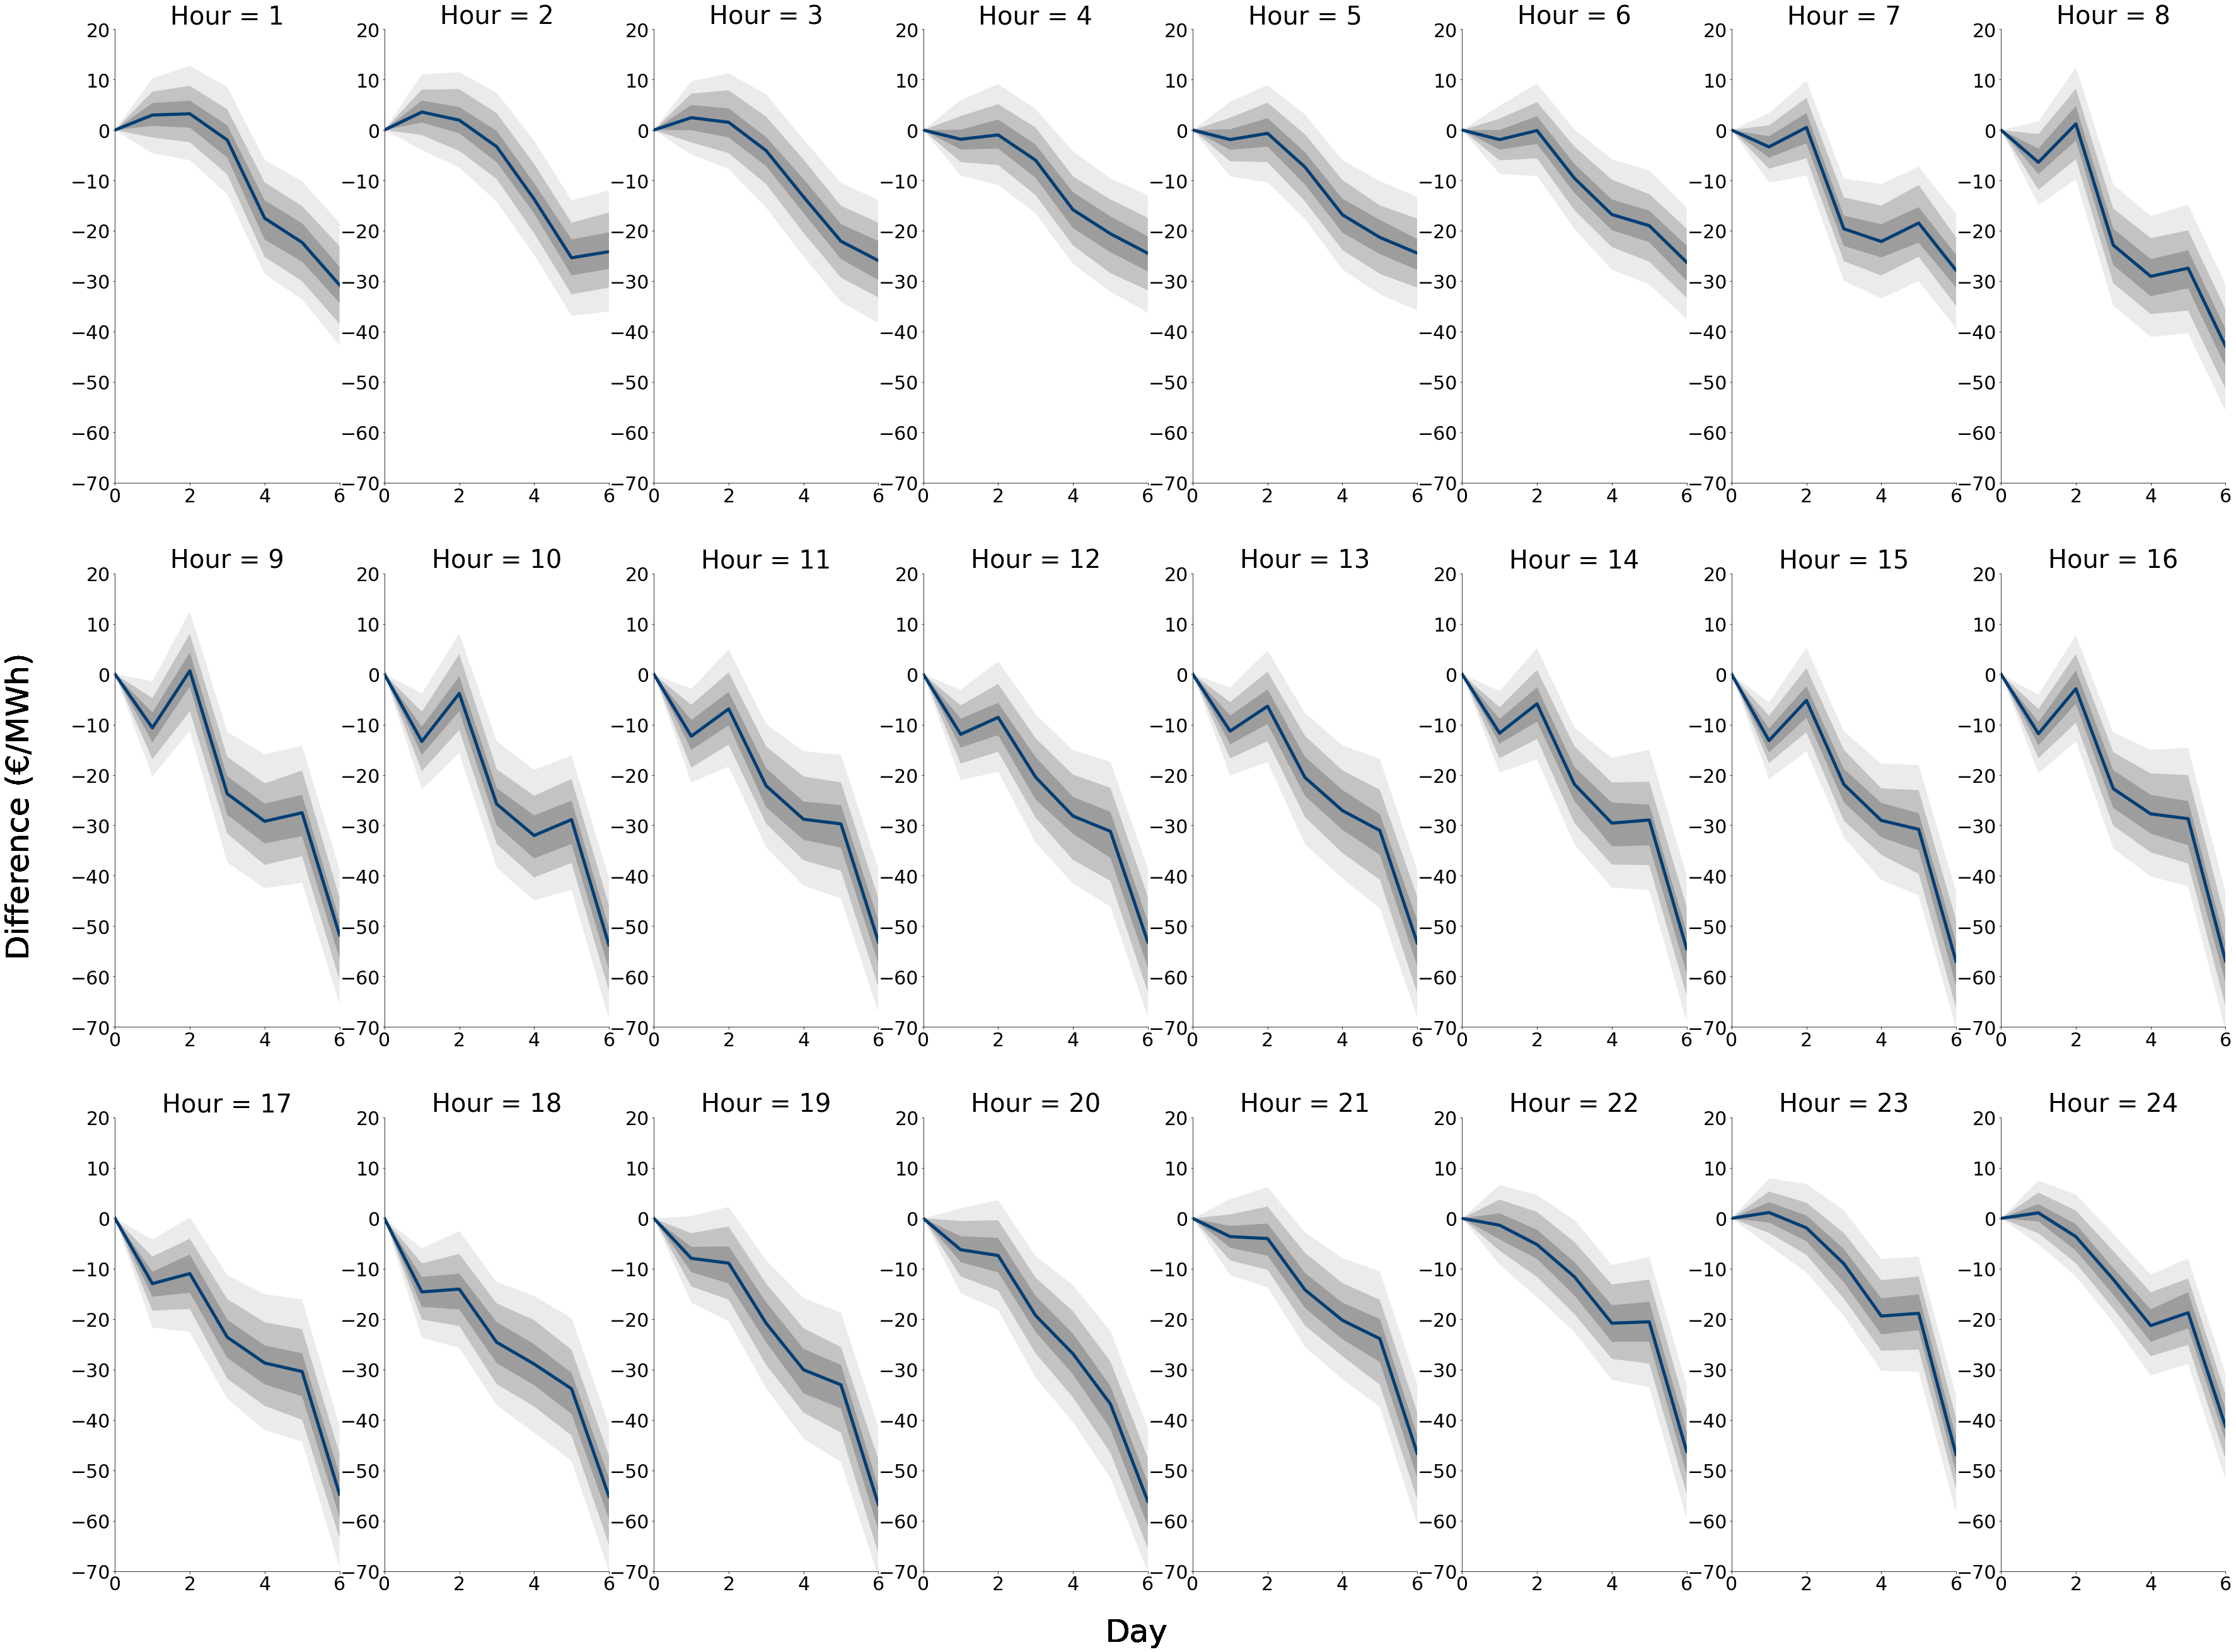

In [10]:
fig, axis = plt.subplots(3, 8, figsize=(60, 45))
percentiles_alpha = [0.2, 0.5, 1]
quantile = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        hour_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        
        percentile_df = hour_diff_df.loc[h].quantile(q=quantile, axis=1)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                percentile_df.columns, percentile_df.loc[quantile[k]], percentile_df.loc[quantile[-k-1]],
                facecolor=ImperialColors.cool_grey.value, alpha=alpha_value
            )
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 6)
        ax.set_ylim(-70, 20)
        ax.tick_params(axis="both", labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)

### Train neural ODE to learn external drift

In [402]:
def get_multivariate_batch(train_df: pd.DataFrame, t: int):
    batch_y = np.zeros((t+1, 20, 1, 24)) # shape: (time, batch_size, 1, obs_dim)
    batch_t = torch.from_numpy(np.arange(t+1, dtype=np.float64))
    col_indexes = np.random.choice(train_df.columns, size=20, replace=False) # pick batch_size columns
    # iterate through each timestamp to get array of shape (batch_zise, 1, obs_dim)
    for h in range(t+1):
        batch_y[h] = train_df[col_indexes].xs(h, level=1, drop_level=False).T.values.reshape(20, 1, 24)
    batch_y0 = torch.from_numpy(batch_y[0]).float()
    batch_y = torch.from_numpy(batch_y)
        
    return batch_y0, batch_t, batch_y

def get_mean_tensor_from_trajectories(traj_df: pd.DataFrame, hour: int):
    tensor_1d = traj_df.xs(hour, level=1, drop_level=False).mean(axis=1).values
    tensor_1d = torch.from_numpy(tensor_1d.reshape(1, 1, -1)).float().to(device)
    
    return tensor_1d

def plot_training_evaluation(pred: torch.tensor, train_df: pd.DataFrame):
    fig, axis = plt.subplots(3, 8, figsize=(60, 45))

    pred_df = pd.DataFrame(pred.reshape(-1, 24).T, index=np.arange(1, 25))
    
    for i, ax_list in enumerate(axis):
        for j, ax in enumerate(ax_list):
            h = 1 + i*8+j
            hour_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
            pred_df.loc[h].plot(ax=ax, lw=5, color=ImperialColors.dark_green.value)
    
            ax.set_xlabel("")
            ax.set_title(f"Hour = {h}", fontsize=40)
            ax.set_xlim(0, pred_df.shape[-1] + 1)
            ax.set_ylim(-70, 20)
            ax.tick_params(axis="both", labelsize=30)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
    fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
    fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)

Iteration 1: 0000 | total loss 5.279061 | Time: 0.00 mins


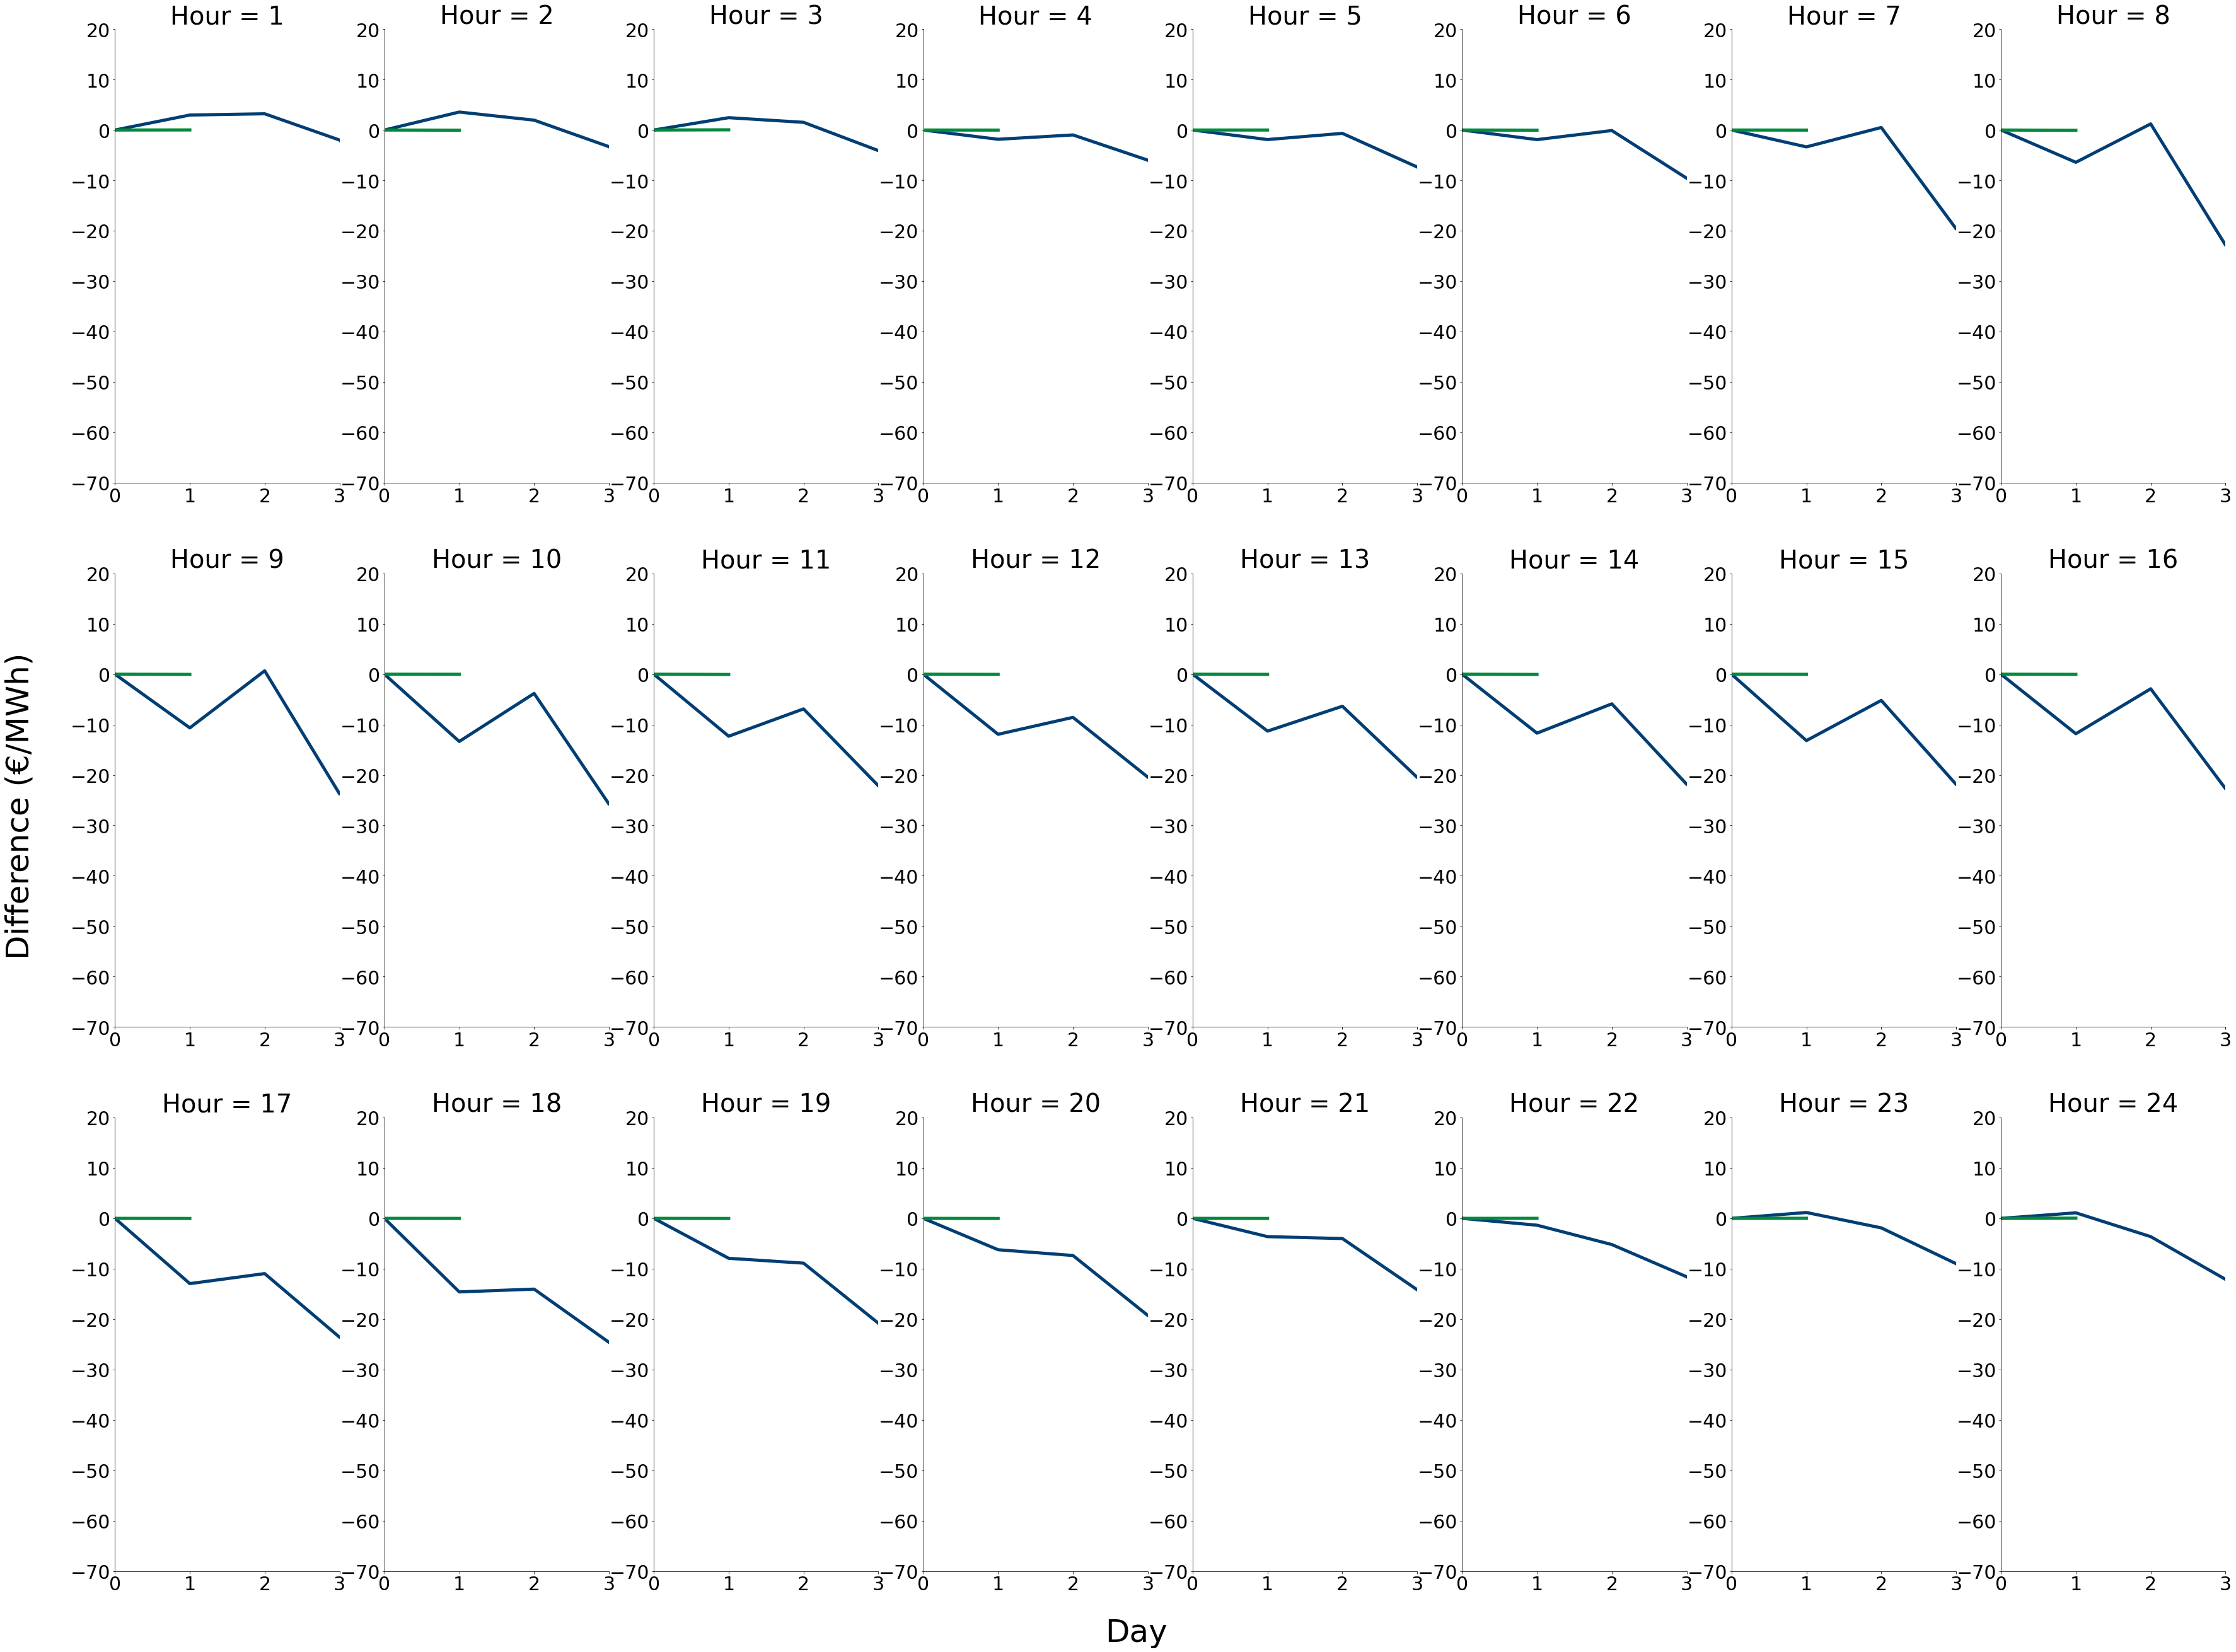

Iteration 1: 0500 | total loss 3.765576 | Time: 0.49 mins


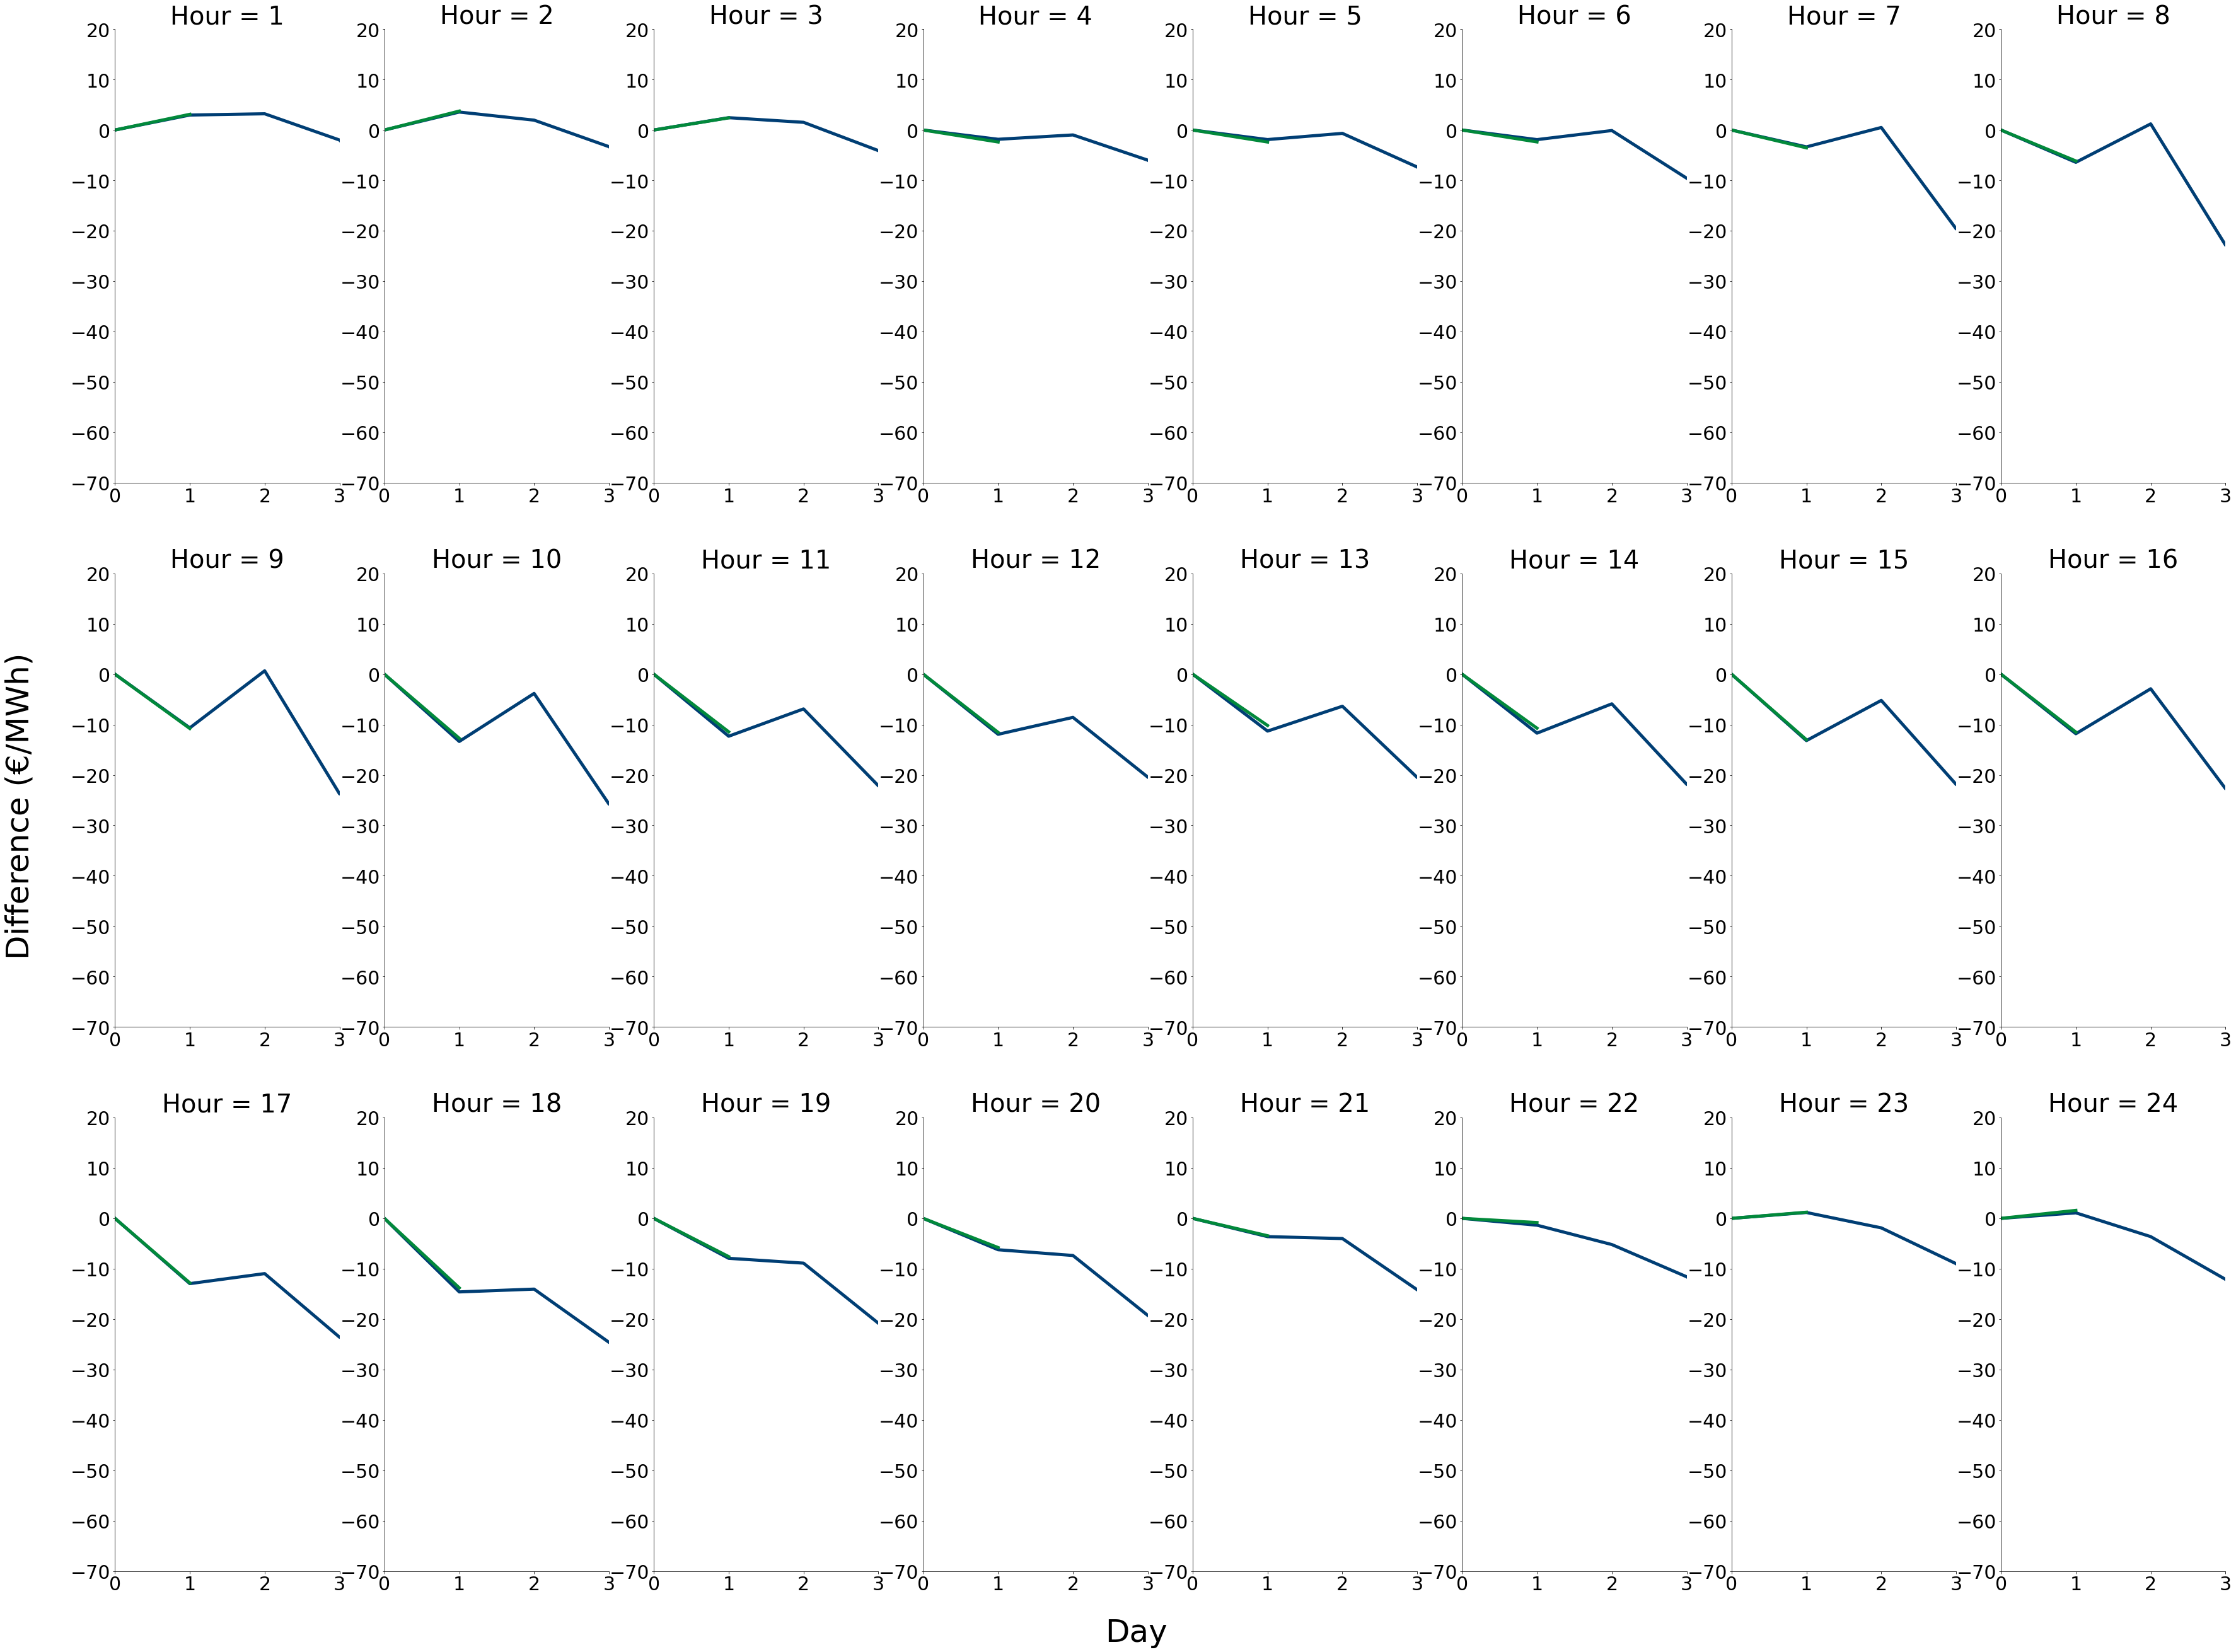

Iteration 1: 1000 | total loss 3.734782 | Time: 0.99 mins


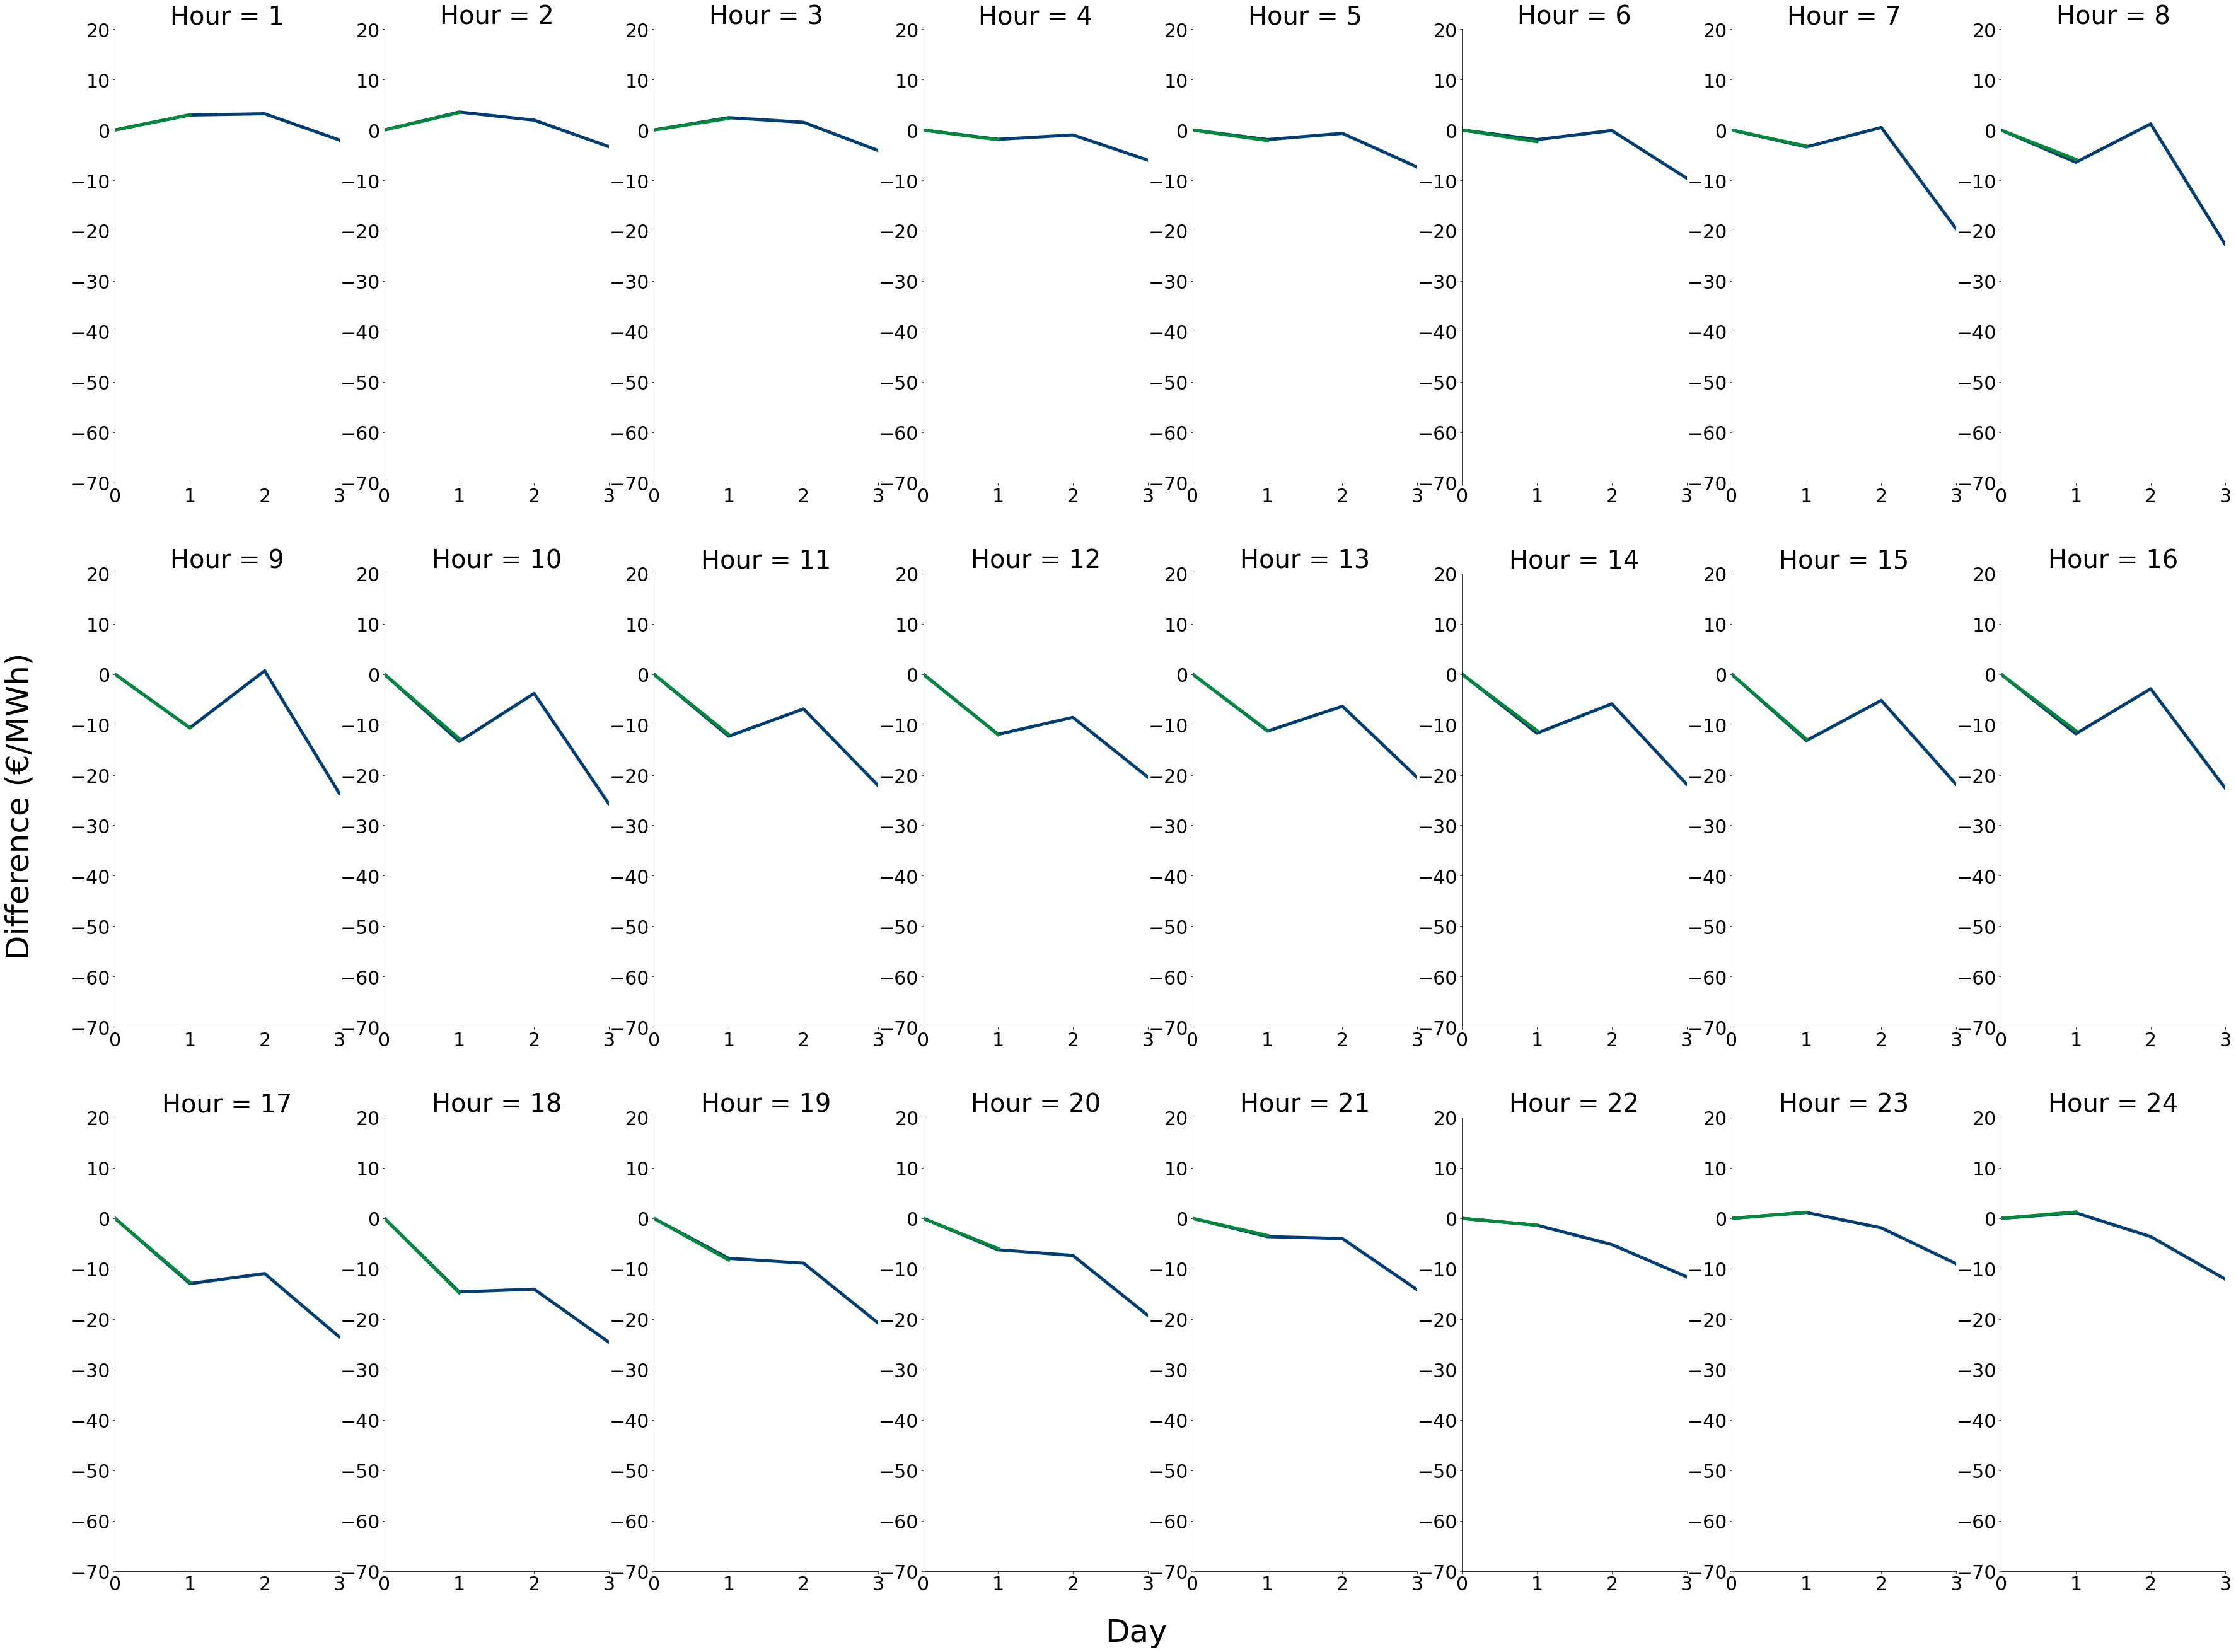

Iteration 1: 1500 | total loss 3.857646 | Time: 1.50 mins


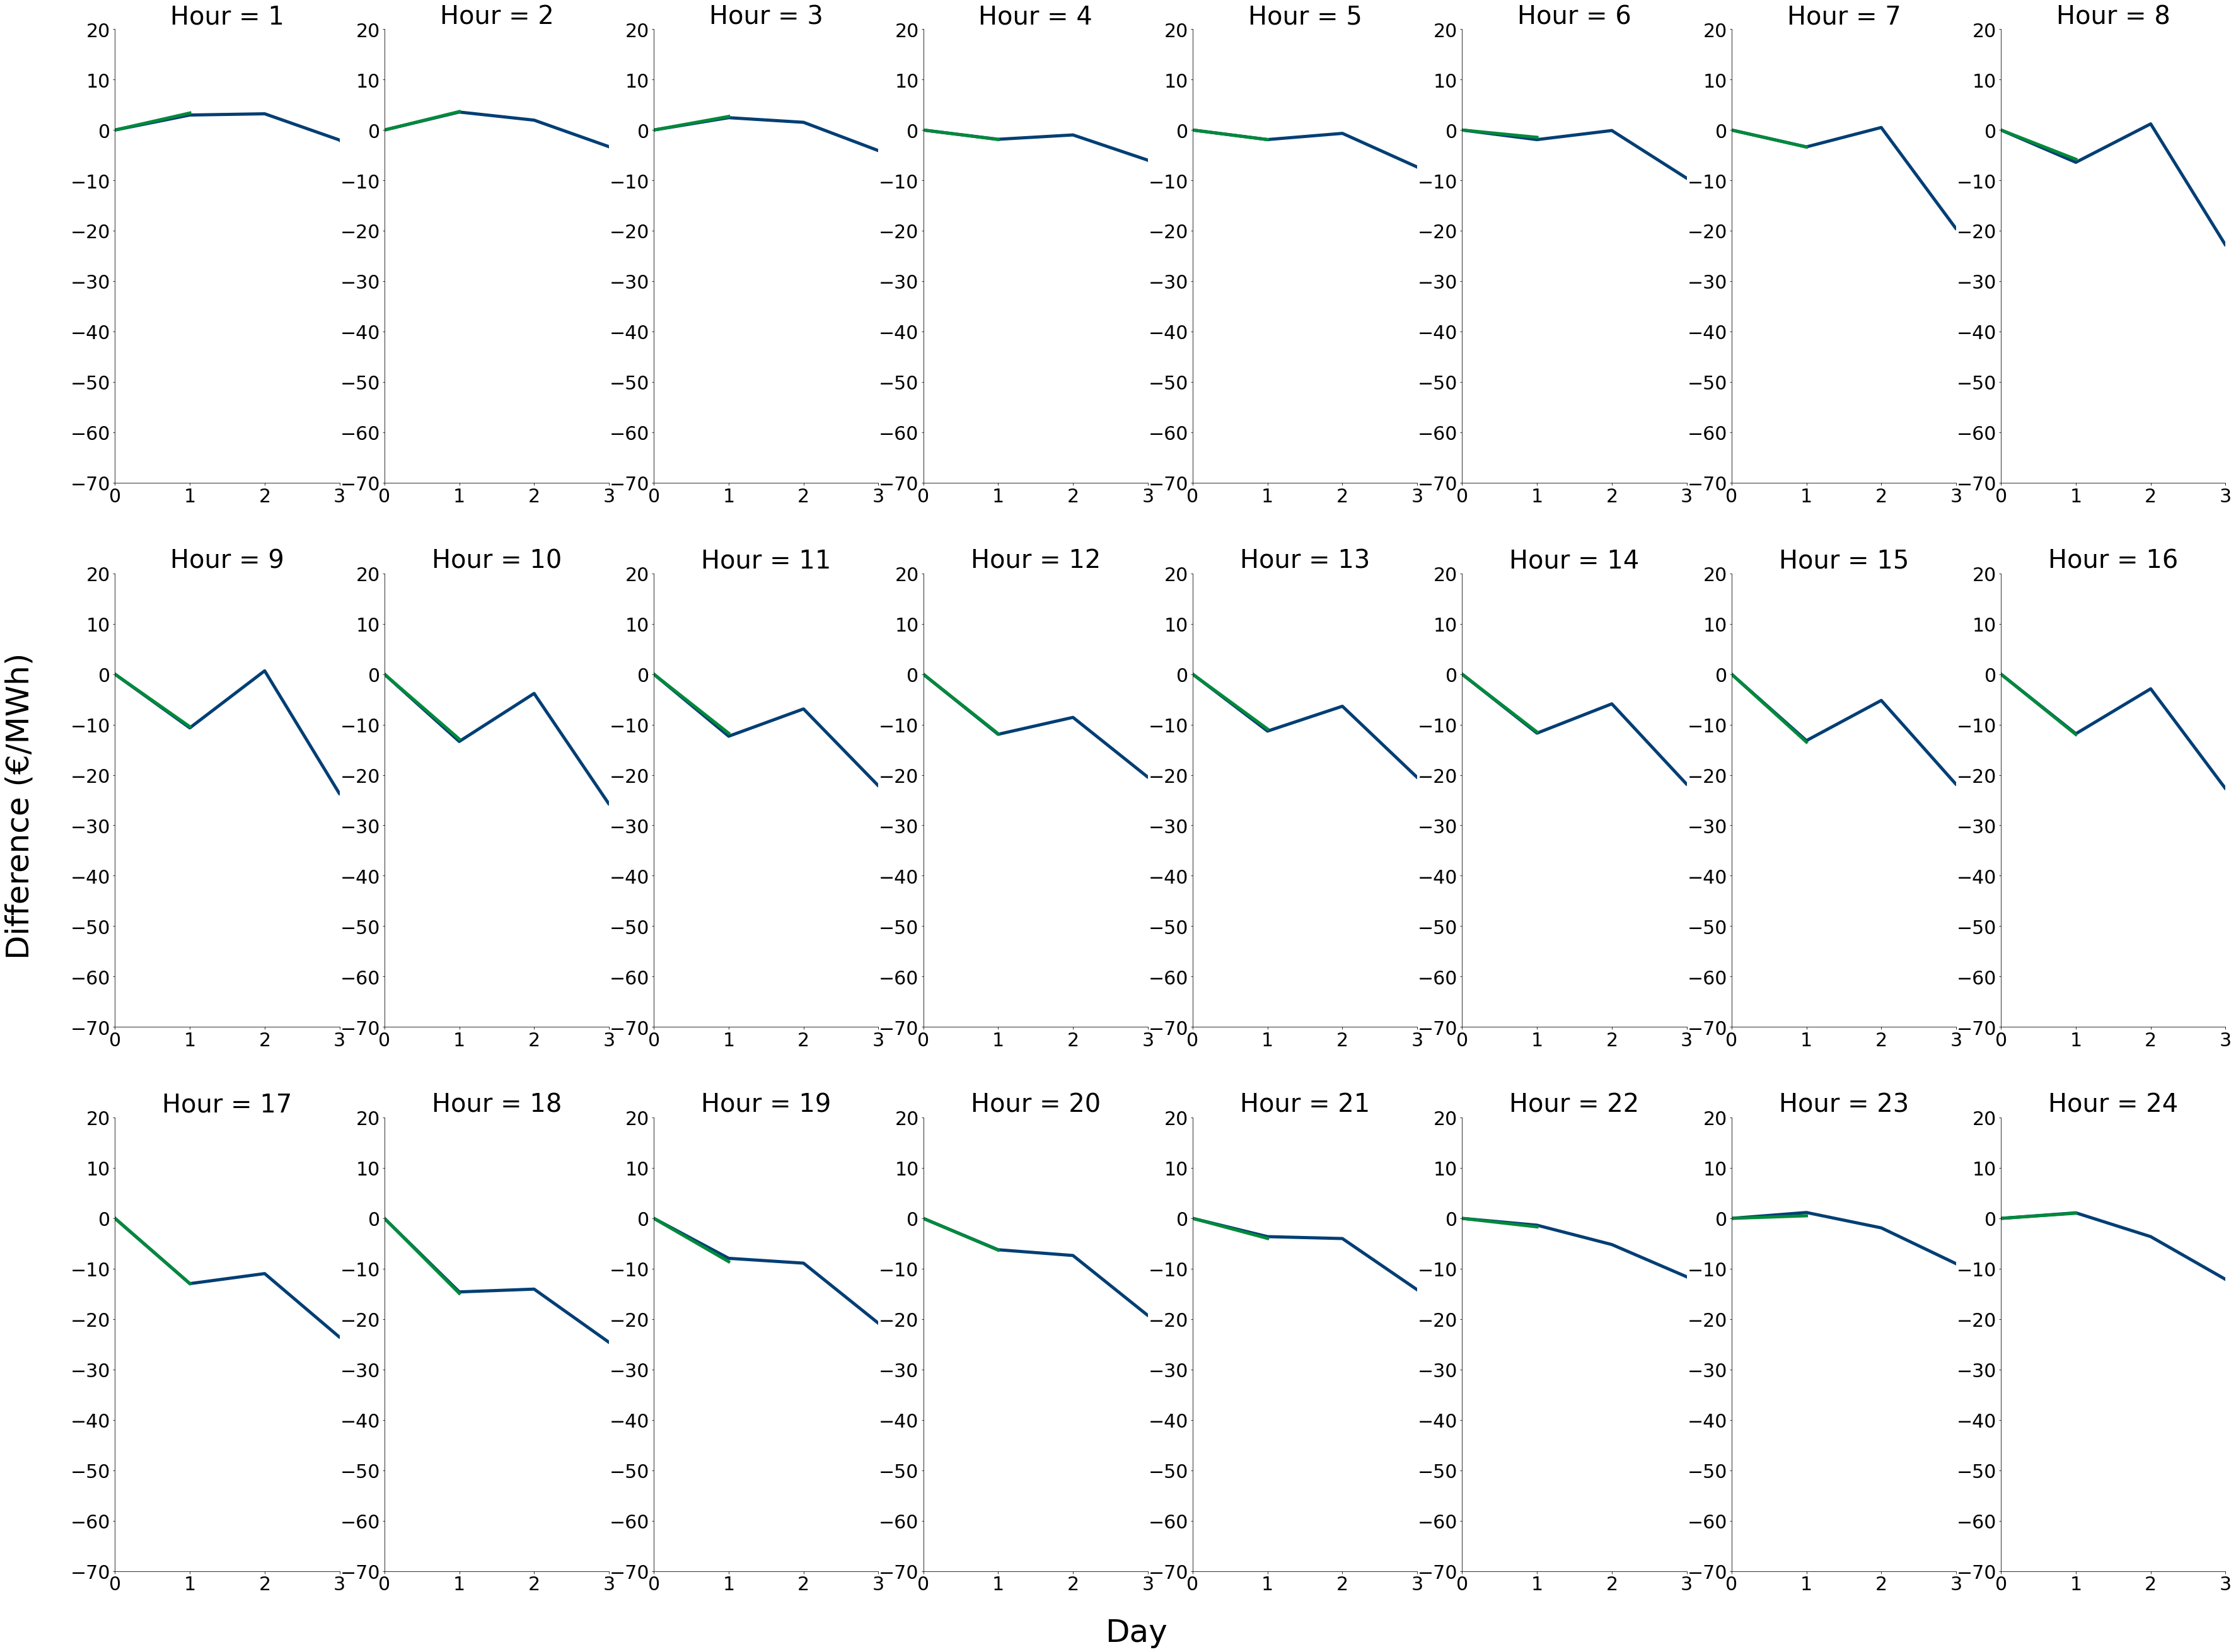

In [403]:
device = torch.device("cpu")

init_window_length = 0
time_step = 1

func = ODEfunc(obs_dim=24, hidden_layer_1=24*4).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for j in range(1, 2):
    trajectory_time = init_window_length + time_step*j
    
    start = time.time()
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    
    for itr in range(0, 1_500+1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_multivariate_batch(train_df=hour_diff_df, t=trajectory_time)
        batch_y0 = batch_y0.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)

        pred_y = odeint(func, batch_y0, batch_t).to(device)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())
        end = time.time()
        training_time = (end-start) / 60

        if itr % 500 == 0:
            print(f"Iteration {j}: {itr:04d} | total loss {loss_meter.avg:.6f} | Time: {training_time:.2f} mins")
            # evaluate training set
            true_y0 = get_mean_tensor_from_trajectories(traj_df=hour_diff_df, hour=0)
            
            with torch.no_grad():
                pred_y = odeint(func, true_y0, batch_t)
                plot_training_evaluation(pred=pred_y, train_df=hour_diff_df)
                plt.show()
                
                # Predict for test set and compute loss 
            
            print("="*115)
                